In [42]:
# Set environment variables before importing libraries that may initialize OpenMP
# This reduces the chance of multiple OpenMP runtimes (libiomp5md) being initialized
import os
# Unsafe but practical workaround for Windows OpenMP conflicts; keeps the kernel alive.
# If you'd prefer not to use this, see notes below for safer long-term fixes.
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")

'1'

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from pathlib import Path
import os
import math
from torch.utils.data import Dataset, DataLoader

## Hyper-parameters (global)
- HISTORY_LEN = 20: number of past time steps used to predict the next one.
- Patch radius r: the spatial neighbourhood radius. The patch length is (2r+1) and must be odd.


In [44]:
HISTORY_LEN = 20
r = 1
patch_size = 2 * r + 1  # doit rester cohérent partout

NUM_EPOCHS = 10
ROLLOUT_TRAIN_STEPS = 3

assert patch_size >= 3 and patch_size % 2 == 1, "patch_size doit être impair >=3"
print("OK: patch_size =", patch_size)

OK: patch_size = 3


#### Load training data & Dataset definition

We group multiple generated Burgers trajectories by viscosity (ν) and build a single
PyTorch Dataset/DataLoader.
Each sample provides:
- initial_field → the field at t=0,
- full_trajectory → a tensor of shape (T, N),
- nu → viscosity metadata (not used by the CNN here).


In [45]:
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

class BurgersViscosityDataset(Dataset):
    def __init__(self, datasets, viscosities):
        """
        datasets: list of Tensors, each of shape (num_examples, T, N) for different viscosities
        viscosities: list or Tensor of corresponding viscosity scalars (floats)
        """
        self.data = []
        self.nu = []

        for data, nu in zip(datasets, viscosities):
            time_instances = data.shape[0]
            self.data.append(data)
            # Create tensor of shape (time_instances, 1) with viscosity nu repeated
            self.nu.append(torch.full((time_instances, 1), nu, dtype=torch.float32))
        
        self.data = torch.cat(self.data, dim=0)  # (total_samples, T, N)
        self.nu = torch.cat(self.nu, dim=0)      # (total_samples, 1)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        # Return (initial_field, full_trajectory, viscosity)
        full_trajectory = self.data[idx]          # (T, N)
        initial_field = full_trajectory[0, :]     # (N,)
        nu = self.nu[idx]                         # (1,)
        return initial_field, full_trajectory, nu



#### Helpers to load .npz files (factorized logic)

`_extract_U_and_nu_from_npz` is the single source of truth for reading a file.
Both `load_burgers_npz_file` (debug, single file) and `collect_generated_burgers`
(full dataset, subfolders) rely on it.

<span style="color: blue;">
Correction of the padding,

- No more time padding => No duplication of time steps
- Symetrical space pading 
</span>

In [46]:

def _extract_U_and_nu_from_npz(path):
    """
    Load a Burgers npz file and extract:
    - U: array (T, N)
    - nu: viscosity (float, default 0.1 if missing)
    """
    data = np.load(str(path), allow_pickle=True)

    # viscosity
    if 'nu' in data.files:
        nu = float(data['nu'])
    else:
        nu = 0.1  # fallback default

    # field U
    if 'U' in data.files:
        U = np.asarray(data['U'])
    elif 'u' in data.files:
        U = np.asarray(data['u'])
    else:
        chosen = None
        for k in data.files:
            if k not in ('x', 't', 'dx', 'dt', 'nu', 'speed', 'tag'):
                chosen = data[k]
                break
        if chosen is None:
            chosen = data[data.files[0]]
        U = np.asarray(chosen)

    # Ensure 2D: (T, N)
    if U.ndim == 1:
        U = U[np.newaxis, :]
    elif U.ndim > 2:
        U = U.reshape(U.shape[0], -1)

    return U, nu


def load_burgers_npz_file(file_path):
    """
    Simple loader for a *single* npz file, useful for quick inspection/debugging.
    Returns a tensor of shape (T, N).
    """
    U, _ = _extract_U_and_nu_from_npz(file_path)
    return torch.tensor(U, dtype=torch.float32)


def _align_array_to_shape(arr, target_T, target_N):
    """
    Aligne un tableau (T, N) vers (target_T, target_N).

    --- TEMPS (axe 0) ---
    - Si T < target_T : ValueError → le fichier doit être filtré en amont.
    - Si T > target_T : on tronque aux target_T premiers pas de temps.
    - Aucun padding temporel n'est jamais appliqué.

    --- ESPACE (axe 1) ---
    - Si N < target_N : padding symétrique (left/right ≈ moitié-moitié) avec edge padding.
    - Si N > target_N : crop centré.
    """
    arr = np.asarray(arr)
    if arr.ndim == 1:
        arr = arr[np.newaxis, :]

    T, N = arr.shape

    # --- TIME ALIGNMENT ---
    if T < target_T:
        raise ValueError(
            f"Sequence too short in time: T={T} < target_T={target_T}. "
            "You must filter this file before alignment."
        )
    elif T > target_T:
        arr = arr[:target_T, :]  # truncate

    # --- SPACE ALIGNMENT ---
    if N < target_N:
        pad = target_N - N
        left = pad // 2
        right = pad - left
        arr = np.pad(arr, ((0, 0), (left, right)), mode='edge')

    elif N > target_N:
        excess = N - target_N
        left = excess // 2
        right = left + target_N
        arr = arr[:, left:right]

    return arr



def collect_generated_burgers(root_dir, align=True):
    """
    Charge tous les fichiers .npz du dossier (et sous-dossiers).
    
    - Filtre les fichiers trop courts : T < history_len + 1
    - Groupe par viscosité `nu`
    - Choisit un target_T = min(Ts) pour ce groupe (pas de padding en temps)
    - Choisit un target_N = max(Ns)
    - Aligne chaque U avec _align_array_to_shape (truncate time + symmetric spatial padding)
    """

    root_dir = Path(root_dir)
    npz_files = sorted(root_dir.glob("**/*.npz"))
    if len(npz_files) == 0:
        raise FileNotFoundError(f"No .npz files found under {root_dir}")

    MIN_T_REQUIRED = HISTORY_LEN + 1

    groups = {}
    shapes = {}

    # --- Scan & filter ---
    for p in npz_files:
        U, nu = _extract_U_and_nu_from_npz(p)
        T, N = U.shape

        if T < MIN_T_REQUIRED:
            print(f"Skipping {p.name}: T={T} < MIN_T_REQUIRED={MIN_T_REQUIRED}")
            continue

        groups.setdefault(nu, []).append(U)
        shapes.setdefault(nu, []).append((T, N))

    datasets = []
    viscosities = []

    # --- Process each viscosity group ---
    for nu, arrs in groups.items():
        Ts = [a.shape[0] for a in arrs]
        Ns = [a.shape[1] for a in arrs]

        target_T = min(Ts)  # no temporal padding → truncate only
        target_N = max(Ns)  # spatial padding allowed

        aligned = []
        for a in arrs:
            try:
                a2 = _align_array_to_shape(a, target_T, target_N)
                aligned.append(a2)
            except ValueError as e:
                print(f"Skipping file for nu={nu}: {e}")

        if len(aligned) == 0:
            print(f"No valid data for nu={nu}, skipping group.")
            continue

        arr_tensor = torch.tensor(np.stack(aligned, axis=0), dtype=torch.float32)

        datasets.append(arr_tensor)
        viscosities.append(float(nu))

    return datasets, viscosities


#### Build Dataset & DataLoader

We now collect all Burgers `.npz` files from a root directory (with subfolders),
group them by viscosity, and wrap everything into a single PyTorch dataset.

<span style="color: blue;">
Use a train and test data splited in this code instead of spliting using the generation script
</span>


In [47]:
root_dir = "generated_1d_burgers/train"  # Fixed path - removed "NFTM_for_Physic/" since we're already in that directory

datasets, viscosities = collect_generated_burgers(root_dir, align=True)

full_dataset = BurgersViscosityDataset(datasets, viscosities)

n_total = len(full_dataset)
train_ratio = 0.8

n_train = int(train_ratio * n_total)
n_test = n_total - n_train

train_dataset, test_dataset = random_split(
    full_dataset,
    [n_train, n_test],
    generator=torch.Generator().manual_seed(42)  # pour la reproductibilité
)

batch_size = 16  # à ajuster

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print("Total samples:", n_total)
print("Train samples:", len(train_dataset))
print("Test  samples:", len(test_dataset))

# Juste un sanity check sur un batch train
initial_field, full_trajectory, nu = next(iter(train_loader))
print(" initial_field shape:", initial_field.shape)     # (B, N)
print(" full_trajectory shape:", full_trajectory.shape) # (B, T, N)
print(" nu shape:", nu.shape)                           # (B, 1)

Total samples: 800
Train samples: 640
Test  samples: 160
 initial_field shape: torch.Size([16, 128])
 full_trajectory shape: torch.Size([16, 256, 128])
 nu shape: torch.Size([16, 1])


## Shape checks

In [48]:
def check_controller_in_channels(model, expected_in):
    cin = model.conv1.in_channels
    assert cin == expected_in, f"in_channels={cin} ≠ expected={expected_in}"
    print(f"OK: CNNController.conv1.in_channels = {cin}")

def check_controller_output_scalar(model):
    cout_k = model.output_layer.kernel_size[0]
    assert cout_k == 1, "La couche de sortie doit être 1x1 (mélange de canaux uniquement)"
    print("OK: output_layer kernel_size=1")

## CNN controller
The CNN acts as the NFTM controller, processing patches independently across the field.


In [49]:
class CNNController(nn.Module):
    def __init__(self, patch_size):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=HISTORY_LEN, out_channels=8, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=1)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.spatial_reduce = nn.AdaptiveAvgPool1d(output_size=1)
        self.output_layer = nn.Conv1d(in_channels=8, out_channels=1, kernel_size=1)

    def forward(self, x):
        # x: (B*N, L, patch_size)
        x = self.conv1(x)           # (B*N, 8, patch_size)
        x = self.act1(x)
        x = self.pool(x)            # (B*N, 8, patch_size-1)
        x = self.conv2(x)           # (B*N, 8, patch_size-1)
        x = self.act2(x)
        x = self.spatial_reduce(x)  # (B*N, 8, 1)
        x = self.output_layer(x)    # (B*N, 1, 1)
        return x

cnn_controller = CNNController(patch_size)
check_controller_in_channels(cnn_controller, HISTORY_LEN)
check_controller_output_scalar(cnn_controller)

OK: CNNController.conv1.in_channels = 20
OK: output_layer kernel_size=1


Helper to refactor the data

In [50]:
def build_patches_from_sequence(fields_seq, r, patch_size):
    """
    fields_seq: (B, L, N)  -> L = HISTORY_LEN dernières étapes
    Retourne: (B*N, L, patch_size) pour alimenter le CNN.

    Pour chaque time-step l de [0..L-1], on :
      - pad le champ spatial (B, N) par réplication des bords,
      - extrait toutes les fenêtres de taille `patch_size`,
      - empile tout et on reformate en (B*N, L, patch_size).
    """
    B, L, N = fields_seq.shape
    patches_list = []

    for l in range(L):
        field_l = fields_seq[:, l, :]                        # (B, N)
        padded_l = F.pad(field_l, (r, r), mode='replicate')  # (B, N + 2r)
        patches_l = padded_l.unfold(1, patch_size, 1)        # (B, N, patch_size)
        patches_list.append(patches_l)

    patches_seq = torch.stack(patches_list, dim=2)           # (B, N, L, patch_size)
    return patches_seq.reshape(B * N, L, patch_size)         # (B*N, L, patch_size)

<span style="color: blue;">
Correction of the RNN, ensure the L time steps from "HISTORY_LEN =" are all see as L diffrent input channels in the network
</span>

`fields_seq = full_trajectory[:, t-HISTORY_LEN:t, :]   # (B, L, N)`
`patches_input = build_patches_from_sequence(
    fields_seq, r, patch_size
)  # (B*N, L, patch_size)`

In [51]:
def negative_r2_loss(pred, target, eps=1e-8):
    """
    Implémente la perte -R² :
        R² = 1 - SSR / SST
        loss = -R² = SSR/SST - 1
    où :
        SSR = sum( (y - ŷ)^2 )
        SST = sum( (y - mean(y))^2 )
    """
    # erreurs quadratiques
    ssr = torch.sum((target - pred)**2)

    # variance totale autour de la moyenne
    mean_target = torch.mean(target)
    sst = torch.sum((target - mean_target)**2) + eps  # éviter division par 0

    r2 = 1 - ssr / sst
    return -r2


## Training setup

<span style="color: blue;">

- Using test/train set

- Computing rollout during training
</span>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

cnn_controller.to(device)

mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_controller.parameters(), lr=1e-3)

  # nombre d'étapes de rollout pendant le training

train_losses = []
test_losses  = []

for epoch in range(NUM_EPOCHS):
    # --------- TRAIN ---------
    cnn_controller.train()
    total_train_loss = 0.0

    for initial_field, full_trajectory, nu in train_loader:
        optimizer.zero_grad()

        full_trajectory = full_trajectory.to(device)  # (B, T, N)
        B, T, N = full_trajectory.shape
        assert T >= HISTORY_LEN + ROLLOUT_TRAIN_STEPS, "Séquence trop courte pour ce training"

        losses_all_starts = []

        # On parcourt des temps de départ t0
        # t0 est le premier temps qu'on va prédire pendant ce mini-rollout
        max_start = T - ROLLOUT_TRAIN_STEPS
        for t0 in range(HISTORY_LEN, max_start):
            # Fenêtre initiale: HISTORY_LEN steps de GT avant t0
            window = full_trajectory[:, t0-HISTORY_LEN:t0, :].clone()  # (B, L, N)

            # Rollout auto-régressif pendant ROLLOUT_TRAIN_STEPS steps
            for k in range(ROLLOUT_TRAIN_STEPS):
                # Prépare les patches (B*N, L, patch_size)
                patches_input = build_patches_from_sequence(window, r, patch_size)

                # Prédiction au temps t = t0 + k
                pred_t = cnn_controller(patches_input).reshape(B, N)  # (B, N)
                target_t = full_trajectory[:, t0 + k, :]              # (B, N)

                loss_t = mse_loss(pred_t, target_t)
                losses_all_starts.append(loss_t)

                # Mise à jour de la fenêtre:
                # on enlève le plus ancien step, on ajoute la prédiction
                window = torch.cat(
                    [window[:, 1:, :], pred_t.unsqueeze(1)], dim=1
                )  # (B, L, N) toujours

        if len(losses_all_starts) == 0:
            continue

        batch_loss = torch.stack(losses_all_starts).mean()
        batch_loss.backward()
        optimizer.step()

        total_train_loss += batch_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --------- TEST ---------
    cnn_controller.eval()
    total_test_loss = 0.0
    num_test_batches = 0

    with torch.no_grad():
        for initial_field, full_trajectory, nu in test_loader:
            full_trajectory = full_trajectory.to(device)
            B, T, N = full_trajectory.shape
            if T < HISTORY_LEN + ROLLOUT_TRAIN_STEPS:
                continue

            losses_all_starts = []
            max_start = T - ROLLOUT_TRAIN_STEPS

            for t0 in range(HISTORY_LEN, max_start):
                window = full_trajectory[:, t0-HISTORY_LEN:t0, :].clone()

                for k in range(ROLLOUT_TRAIN_STEPS):
                    patches_input = build_patches_from_sequence(window, r, patch_size)
                    pred_t = cnn_controller(patches_input).reshape(B, N)
                    target_t = full_trajectory[:, t0 + k, :]

                    loss_t = mse_loss(pred_t, target_t)
                    losses_all_starts.append(loss_t)

                    window = torch.cat(
                        [window[:, 1:, :], pred_t.unsqueeze(1)], dim=1
                    )

            if len(losses_all_starts) == 0:
                continue

            batch_loss = torch.stack(losses_all_starts).mean()
            total_test_loss += batch_loss.item()
            num_test_batches += 1

    if num_test_batches > 0:
        avg_test_loss = total_test_loss / num_test_batches
    else:
        avg_test_loss = float('nan')

    test_losses.append(avg_test_loss)

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} | "
        f"train rollout-MSE: {avg_train_loss:.6f} | "
        f"test rollout-MSE: {avg_test_loss:.6f}"
    )


Using device: cuda
Epoch 1/10 | train rollout-MSE: 0.175913 | test rollout-MSE: 0.133250
Epoch 2/10 | train rollout-MSE: 0.083314 | test rollout-MSE: 0.024148
Epoch 3/10 | train rollout-MSE: 0.006301 | test rollout-MSE: 0.002526
Epoch 4/10 | train rollout-MSE: 0.002144 | test rollout-MSE: 0.001718
Epoch 5/10 | train rollout-MSE: 0.001540 | test rollout-MSE: 0.001265
Epoch 6/10 | train rollout-MSE: 0.001181 | test rollout-MSE: 0.000999


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (10,) and (6,)

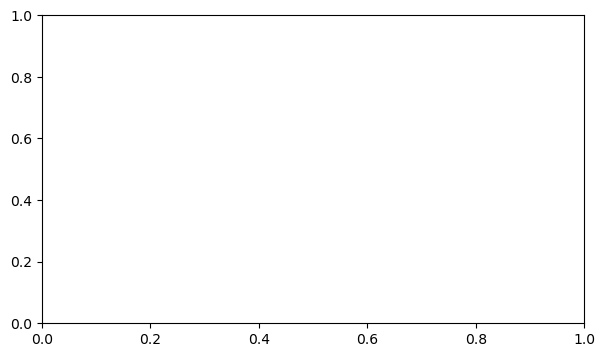

In [53]:
plt.figure(figsize=(7, 4))
plt.plot(range(1, NUM_EPOCHS+1), train_losses, marker='o', label='Train -R²')
plt.plot(range(1, NUM_EPOCHS+1), test_losses,  marker='s', label='Test -R²')
plt.xlabel("Epoch")
plt.ylabel("Loss (-R²)")
plt.title("Évolution de la loss -R² (train vs test)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()


## Visualization helper

In [ ]:
def visualize_h(field_pred, field_true, sample_idx=0, symmetric=False):
    """
    Affiche GT vs Pred avec la même échelle de couleurs.
    - symmetric=True force une échelle [-M, M] (utile si les champs sont centrés).
    field_pred, field_true : (B, T, N)
    """
    pred = field_pred[sample_idx].detach().cpu().numpy()  # (T, N)
    true = field_true[sample_idx].detach().cpu().numpy()  # (T, N)

    if symmetric:
        vmax = max(np.abs(pred).max(), np.abs(true).max())
        vmin = -vmax
    else:
        vmin = min(pred.min(), true.min())
        vmax = max(pred.max(), true.max())

    plt.figure(figsize=(12, 5))

    # Ground truth
    plt.subplot(1, 2, 1)
    plt.imshow(true, aspect='auto', cmap='viridis', origin='lower',
               vmin=vmin, vmax=vmax)
    plt.colorbar(label='u(x,t) (GT)')
    plt.xlabel('Spatial position x')
    plt.ylabel('Time step t')
    plt.title('True Trajectories')

    # Prediction
    plt.subplot(1, 2, 2)
    plt.imshow(pred, aspect='auto', cmap='viridis', origin='lower',
               vmin=vmin, vmax=vmax)
    plt.colorbar(label='u(x,t) (Pred)')
    plt.xlabel('Spatial position x')
    plt.ylabel('Time step t')
    plt.title('Predicted Trajectories')

    plt.tight_layout()
    plt.show()


import matplotlib.colors as mcolors
def visualize_error_mixed(field_pred, field_true, sample_idx=0):
    """
    Affiche la carte d'erreur relative:
      - gris pour erreur < 100%
      - rouge pour erreur >= 100%
    Permet de visualiser à la fois les petites et les très grosses erreurs.
    """
    pred  = field_pred[sample_idx].detach().cpu().numpy()
    true  = field_true[sample_idx].detach().cpu().numpy()

    epsilon = 1e-8
    error_percent = np.abs(pred - true) / (np.abs(true) + epsilon) * 100

    # --- Définition des bornes ---
    threshold = 100  # 100%

    # Maximum réel dans les données (possiblement très grand)
    err_max = np.max(error_percent)

    # --- Colormap fusionnée ---
    colors_gray = plt.cm.gray_r(np.linspace(0, 1, 256))
    colors_red  = plt.cm.Reds(np.linspace(0.3, 1, 256))  # commence pas trop clair

    combined_colors = np.vstack((colors_gray, colors_red))
    combined_cmap = mcolors.ListedColormap(combined_colors)

    # Bornes pour la normalisation : 0 → threshold, puis threshold → err_max
    boundaries = np.concatenate([
        np.linspace(0, threshold, 256),
        np.linspace(threshold, err_max, 256)
    ])

    norm = mcolors.BoundaryNorm(boundaries, combined_cmap.N)

    # --- Plot ---
    plt.figure(figsize=(7, 5))
    im = plt.imshow(
        error_percent,
        aspect='auto',
        origin='lower',
        cmap=combined_cmap,
        norm=norm
    )

    cbar = plt.colorbar(im)
    cbar.set_label("Relative Error (%)")

    plt.xlabel("Spatial position x")
    plt.ylabel("Time step t")
    plt.title("Relative Error Map\n(gray <100%, red >100%)")

    plt.tight_layout()
    plt.show()




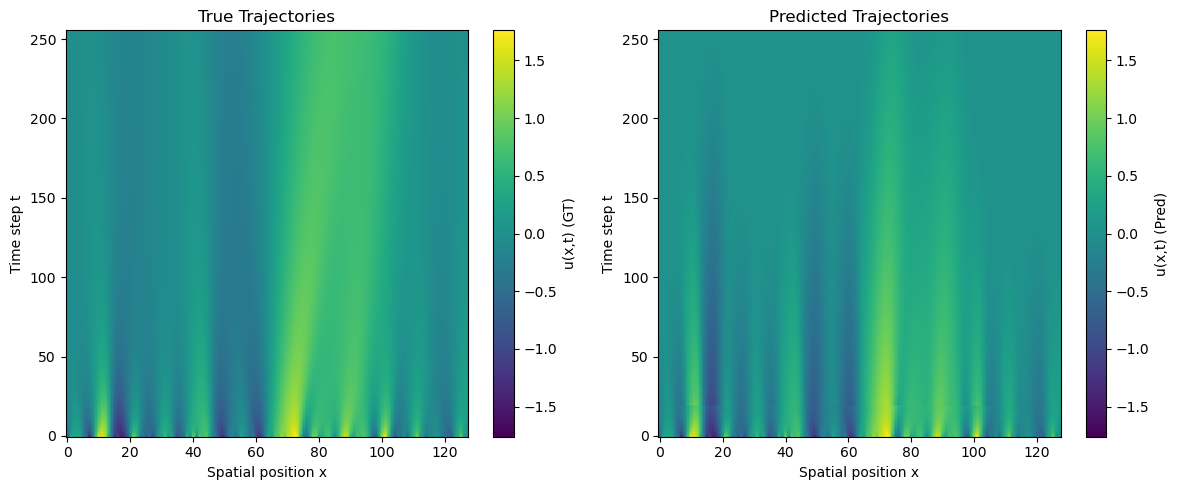

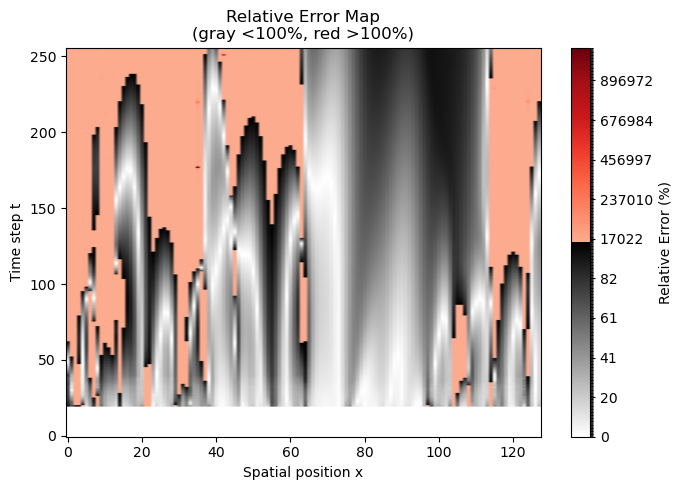

CNNController(
  (conv1): Conv1d(20, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (act1): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (act2): ReLU()
  (spatial_reduce): AdaptiveAvgPool1d(output_size=1)
  (output_layer): Conv1d(8, 1, kernel_size=(1,), stride=(1,))
)

In [54]:
# %% Autoregressive rollout
def rollout_autoregressive(model, full_trajectory, history_len, r, patch_size):
    """
    full_trajectory: (B, T, N) avec les vraies données (utilisées pour warm-up).
    Retourne preds: (B, T, N) avec les prédictions auto-régressives.
    """
    model.eval()
    with torch.no_grad():
        full_trajectory = full_trajectory.to(next(model.parameters()).device)
        B, T, N = full_trajectory.shape

        preds = torch.zeros((B, T, N), device=full_trajectory.device)

        # Warm-up: copier l'historique GT
        preds[:, :history_len, :] = full_trajectory[:, :history_len, :]

        # Fenêtre glissante (B, L, N)
        window = preds[:, :history_len, :].clone()

        for t in range(history_len, T):
            patches_input = build_patches_from_sequence(window, r, patch_size)  # (B*N, L, patch)
            next_pred = model(patches_input).reshape(B, N)                      # (B, N)
            preds[:, t, :] = next_pred

            # glisse la fenêtre : on enlève le plus ancien, on ajoute la nouvelle prédiction
            window = torch.cat([window[:, 1:, :], next_pred.unsqueeze(1)], dim=1)

    return preds


# %% Predict and visualize one batch
cnn_controller.eval()

# Get a random batch from dataloader    
initial_field, full_trajectory, nu = next(iter(dataloader))

# # Get a specific sample from the dataset for consistent testing
# # Load a specific file by name
# file_path = "generated_1d_burgers/test/nu_0.01/burgers_0.npz"  # specify your file path here
# specific_trajectory = load_burgers_npz_file(file_path)  # (T, N)

# # Add batch dimension and create dummy nu value
# full_trajectory = specific_trajectory.unsqueeze(0)  # (1, T, N) - batch size 1
# initial_field = full_trajectory[:, 0, :]  # (1, N)
# nu = torch.tensor([[0.01]], dtype=torch.float32)  # (1, 1) - adjust viscosity value as needed




full_trajectory = full_trajectory.to(device)  # (B, T, N)

# Rollout auto-régressif
predictions = rollout_autoregressive(
    model=cnn_controller,
    full_trajectory=full_trajectory,
    history_len=HISTORY_LEN,
    r=r,
    patch_size=patch_size,
)

# Visualisation GT vs Pred pour le premier échantillon du batch
visualize_h(predictions, full_trajectory, sample_idx=0, symmetric=True)
visualize_error_mixed(predictions, full_trajectory, sample_idx=0)

cnn_controller.train()  # si tu enchaînes sur un autre entraînement ensuite
